### VGG?
VGG: Visual Geometry Group(에서 개발한 모델)

- VGG16의 16: 13개의 합성곱 층 + 3개의 Fully Connected 층
- 이미지 분류 및 인식 분야에서 사용 多 모델
- 심층 합성곱 신경망 中 1
- 3x3 합성곱 필터를 반복적으로 사용
- MaxPooling 사용하여 이미지 크기 축소
- 네트워크가 깊어질수록 채널 수가 늘어남(더 많은 특징 추출 가능)
- 마지막으로 Fully Connected Layer를 통해 분류 작업 수행.






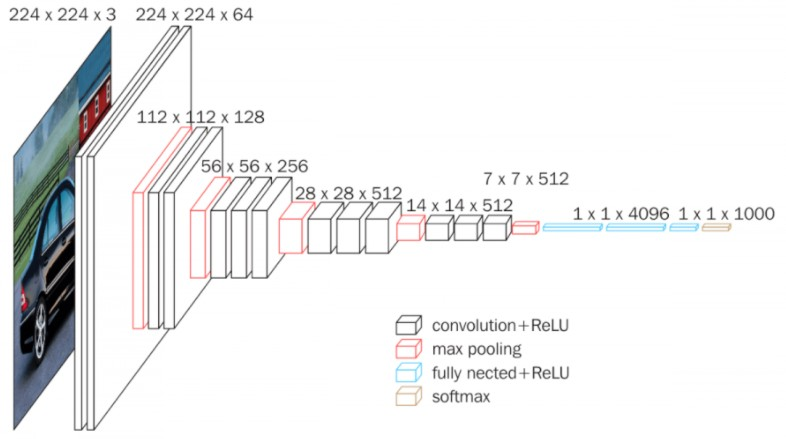

In [1]:
import torch.nn as nn 
import torch.nn.functional as F 

# 2개의 합성곱 층 block 정의 함수
def conv_2_block(in_dim,out_dim): # in_dim: 입력 채널/out_dim: 출력 채널
                                  # 2개의 합성곱 층과 MaxPooling으로 구성된 블록 생성
    model = nn.Sequential( # Sequential=순차적으로 레이어를 쌓는 함수
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1), # 2개 중 첫 번째 합성곱
                                                           # filter: 3X3, padding size: 1 
        nn.ReLU(), # 활성화 함수 ReLU 적용
                   # ReLU: 입력값 x가 0보다 크면 그대로 출력하고, 0 이하면 0 출력
                   # 비선형성을 부여하여 딥러닝 모델이 더 복잡한 함수나 패턴을 학습할 수 있도록 함
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1), # 2개 중 두 번째 합성곱
                                                            # filter: 3X3, padding size: 1 
        nn.ReLU(), # 활성화 함수 ReLU 적용
        nn.MaxPool2d(2,2) # MaxPooling 2X2 필터로 적용하여 출력 크기를 절반으로 감소시키도록 함
    )
    return model
    
# 3개의 합성곱 층 block 정의 함수 
def conv_3_block(in_dim, out_dim): # in_dim: 입력 채널/out_dim: 출력 채널
                                  # 3개의 합성곱 층과 MaxPooling으로 구성된 블록 생성
    model = nn.Sequential( # Sequential=순차적으로 레이어를 쌓는 함수
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),# 3개 중 첫 번째 합성곱
                                                           # filter: 3X3, padding size: 1 
        nn.ReLU(),# 활성화 함수 ReLU 적용
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),# 3개 중 두 번째 합성곱
                                                           # filter: 3X3, padding size: 1 
        nn.ReLU(),# 활성화 함수 ReLU 적용
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),# 3개 중 세 번째 합성곱
                                                           # filter: 3X3, padding size: 1 
        nn.ReLU(),# 활성화 함수 ReLU 적용
        nn.MaxPool2d(2,2) # MaxPooling 2X2 필터로 적용하여 크기를 감소시키도록 함
    )
    return model
    
class VGG16(nn.Module): #  VGG16 모델 구현 class. 입력 이미지: 특징 추출, 최종적: 분류 결과 반환
    def __init__(self,base_dim, num_classes): # base_dim: 첫 번째 블록의 출력 채널 수
                                              # num_classes: 분류할 클래스 수
        super(VGG16, self).__init__() # 부모 클래스 초기화

        # 특징 추출 레이어
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),            # 첫 번째 블록: 입력 채널: 3(R, G, B), 출력 채널: base_dim
            conv_2_block(base_dim,base_dim*2),   # 두 번째 블록에서는 출력 채널을 2배로 증가
            conv_3_block(base_dim*2,base_dim*4), # 세 번째 블록에서도 출력 채널을 2배로 증가
            conv_3_block(base_dim*4,base_dim*8), # 네 번째 블록에서도 출력 채널을 2배로 증가
                                                 # 모델이 단순한 특징뿐만 아니라, 
                                                 # 신경망이 깊어질 수록 더 복잡한 특징을 학습할 수 있어야 하기에
                                                 # 출력 채널 수를 증가시키는 것
                                                 
            conv_3_block(base_dim*8,base_dim*8)  # 다섯 번째 블록에서는 출력 채널 유지
        )

        # Fully Connected Layer
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim,4096),  # 첫 번째 FCL: 입력 크기: 8*base_dim, 출력 크기: 4096
            nn.ReLU(),                   # ReLU 활성화 함수
            nn.Linear(4096,4096),        # 두 번째 FCL: 입력 크기: 4096, 출력 크기: 4096
            nn.ReLU(True),               # ReLU 활성화 함수: inplace=True: 메모리 사용 최적화
            nn.Dropout(),                # 오버피팅 방지를 위해 Dropout을 시행하여 일부 뉴런 비활성화
            nn.Linear(4096,1000),        # 세 번째 FCL: 입력 크기: 4096, 출력 크기: 1000
            nn.ReLU(True),               # ReLU 활성화 함수
            nn.Dropout(),                # Dropout
            nn.Linear(1000,num_classes), # 최종 출력 층: 클래스 수와 일치.
                                         # ImageNet 데이터 셋의 1000개 클래스 중 하나를 예측할 수 있도록
        )
        
    def forward(self,x): # 순전파 함수: 입력 데이터를 받아서 신경망에 통과시킨 후 결과 반환
                         # x: 입력 데이터 (이미지)
                         
        x = self.feature(x)          # 합성곱 층을 통과하여 특징 추출
        x = x.view(x.size(0),-1)      # flatten: Fully Connected에 전달하기 위해서 합성곱 출력을 일렬로 펼침
        x = self.fc_layer(x)         # FCL에 입력
        probas = F.softmax(x,dim=1)  # Softmax를 적용하여 각 클래스에 대한 확률값 반환
        return probas                # Softmax로 변환된 확률 값
        

- 합성곱 레이어와 활성화 함수 ReLU를 이용해서, 이미지의 특징을 추출하는 과정
- MaxPooling을 통해 이미지 size를 줄이며, 정보 유지
- 추출된 특징을 FCL(Fully Connected Layer)에 전달하여, 이미지가 특정 클래스에 속할 확률 계산
- 최종 출력: 입력 이미지가 어떤 클래스에 속하는지 출력